In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Getting the data and preprocessing it

In [2]:
#Loading data into dataframes

data_folder = "datasets"

movies = pd.read_csv(os.path.join(data_folder, "movies.csv")).drop("genres", axis=1) # We do not need genres for our analysis
ratings = pd.read_csv(os.path.join(data_folder, "ratings.csv")).drop("timestamp", axis=1) # timestap not needed too

In [3]:
#Creating a mapping from film_id to film name
movies_mapping = {}
for index, row in movies.iterrows():
    movies_mapping[row.movieId] = row.title

In [5]:
#Leaving only reviews that are either positive or negative and then binarizing them
mask_with_useful_ratings = (ratings.rating >=4)  | (ratings.rating <= 2)

useful_ratings = ratings.loc[mask_with_useful_ratings,:].copy() #Withouth this Pandas was raising a warning about performing operation on slices. 

useful_ratings["rating"] = useful_ratings.rating.apply(lambda x: 1 if x >= 4 else 0)

In [6]:
#Getting number of users and their Id's, moreover I was wondering if I should use test set
#While creating and association rules
users = useful_ratings.userId.unique()
num_of_users = users.size

#size_of_test_set = 0.01
#users_test, users_train = users[:int(num_of_users*size_of_test_set)], users[int(num_of_users*size_of_test_set):]
users_train = users

In [7]:
#Creating 2 separate dataframes one for positive rating and second for negative
useful_ratings_positive = useful_ratings[useful_ratings.rating == 1]
useful_ratings_negative = useful_ratings[useful_ratings.rating == 0]

In [8]:
#one user is our service seems to be a one transaction
#This table is in 1NF and we must instead create a list of reviewed films by every user
positive_transactions = [
    list(useful_ratings_positive[useful_ratings_positive.userId == x].movieId)
    for x in users_train
]

negative_transactions = [
    list(useful_ratings_negative[useful_ratings_negative.userId == x].movieId)
    for x in users_train
]

### inspecting the positive transactions

In [9]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth # use fpgrowth
from mlxtend.frequent_patterns import association_rules

te = TransactionEncoder()
te_array = te.fit_transform(positive_transactions)

In [10]:
df = pd.DataFrame(te_array, columns=te.columns_)

In [11]:
df.shape # So we have only 671 users in the database, and they've commented 6k films, whereas we have 9k in our base

(671, 6170)

Let's count how many films were reviewed how many times.

In [12]:
df.sum().describe() # To include half of a films we would need to set support equal to 2 reviews! Very small number
#Also we have a few films that were reviewed so many times. Maybe these are classic watched by everybody?

count    6170.000000
mean        8.357861
std        18.314944
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       274.000000
dtype: float64

Text(0.5, 1.0, 'Distribution of amount of reviews')

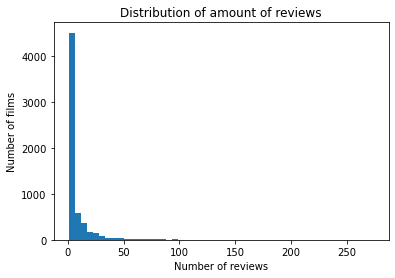

In [14]:
_ = plt.hist(df.sum(), 50)
plt.xlabel("Number of reviews")
plt.ylabel("Number of films")
plt.title("Distribution of amount of reviews")

So we see that most of the films are rather rarely reviewed. Most of them appears only few times, so support for itemsets containing these films will be very small. As a result these films won't be included in any association rule. What to do if user starts watching from these films, what to recommend then?

We have 671 movies, so if we set support to 5% then movie needs to be at least 34 times reviewed so we will reject most of the movies

Moreover movies that were watched many times, may be classics and these are being shown in everyone's basket. So they will
create very big itemsets that do not bring anything new, as everyone likes classic films

So maybe different approach would work better. I think that we are not very interested in very long associations rules, but rather shorter ones
So that based on 2/3 lastly seen movies we can with high precission recommend next 1/2 to watch. `So maybe a good idea would be to restrict the length of itemsets`

### Now let's see how many reviews one users give

In [15]:
df.sum(axis=1).describe()

count     671.000000
mean       76.852459
std       106.181753
min         1.000000
25%        20.000000
50%        41.000000
75%        88.500000
max      1115.000000
dtype: float64

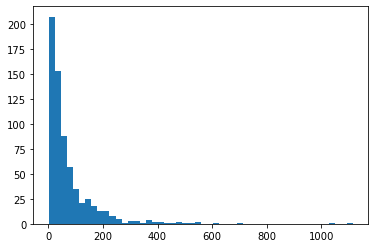

In [16]:
_ = plt.hist(df.sum(axis=1), 50)

Again trend is very similar. Most of the users do not give that many reviews. However, we have some outliers who gave more than 1k positive reviews. Are these critics? Or these are bots that comment everything positively? Should we do anything with them? 

### Creating frequent datasets

Let's try at first typical setting with min support 5% which corresponds to a films being watched 34 times

In [17]:
frequent_itemsets = fpgrowth(df, min_support=0.05, use_colnames=True) #fpgrowth is much faster than apriori

In [18]:
frequent_itemsets.shape

(17197, 2)

In [19]:
positive_ratings_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=5.0)

In [20]:
#Let's calculate how many films the rules covered
all_films = set()
for index, films in positive_ratings_rules.antecedents.iteritems():
    all_films = all_films.union(films)

len(all_films) 

This make no sense to use only 100 films out of 6k possible! So definitelly we need to change the approach and maybe try to restrict length of frequent itemsets.

Let's try some very radical setting to see if we are able to cover more films with it

In [40]:
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True, max_len=3) 
#Basically difference between sizes of frequent itemstets even if we change support by a little here is very big

In [41]:
frequent_itemsets.shape

(2283883, 2)

In [42]:
positive_ratings_rules = association_rules(frequent_itemsets, metric='lift', min_threshold=5.0)

In [43]:
#Let's calculate how many films the rules covered
all_films = set()
for index, films in positive_ratings_rules.antecedents.iteritems():
    all_films = all_films.union(films)

len(all_films) 

1413

Still not that many films. Only 1413 from 6k in corpus (9k in entire database). Probability that first watched film won't be from that pool is about $\frac{1413}{6000} \approx 80\%$, that 2 films are not from that pool about 50% `(I assumed independence and just muliply probabilities in reality this probably differs.)` so it is very likely that even after watching a few films we will still be forced to show some random recomendations.

Moreover some rules may still be conjunctions $A \wedge B -> C$ and we may not have just $A -> C$ in the base (proofed this to myself by simple van diagram). So what if user watched just A? We can make poor assumptions that $A \wedge B ->C <=> A -> C \wedge B -> C$ But this in some cases may give strange results. As an example If someone liked romance and horror then for sure they will like some romance with horror elements but if they just liked romance it make no sense to assume they will like merge of them

Another thing would be to assume symmetricity and one step transitivity of these rules (This is may be closer to the true in case of films than previous assumption). So if user liked movie A, but we do not have any rule A -> X, then we check if we have anything B -> A. Then, we could assume that all rules B -> X, where X is random film hold also for A. So then we can also use movies that are only consequents. But how much more we have then?

In [47]:
#Additionally add consequents to all possible films
for index, films in positive_ratings_rules.consequents.iteritems():
    all_films = all_films.union(films)
len(all_films)

1413

Didn't expected that we won't gain anything... So maybe this symmetricity holds with such a small support?

Last idea I have is to incorporate Multilevel Association Rules and use information about film genres, which I've previously dropped. If rules incorporating ganres will be trivial and not helping at all, then eventually if we do not have information in rules we can just recommend random movie from the same genre as previosuly watched one.

In [56]:
movies_genre = pd.read_csv(os.path.join(data_folder, "movies.csv"))

In [57]:
#Creating a mapping from film_id to [film_name, film_genres] 
movies_mapping_genre = {}
for index, row in movies_genre.iterrows():
    movies_mapping[row.movieId] = []
    movies_mapping[row.movieId].append(row.title)
    movies_mapping[row.movieId].append(row.genres.split("|"))

In [53]:
movies_ganre

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [208]:
class Recommender:
    def __init__(self,positive_rules, negative_rules):
        self.positive_rules = positive_rules
        self.negative_rules = negative_rules

    def recommend_positive(self, previously_watched):
        #first lets check direct matches
        previously_watched = set(previously_watched)
        found_rules = self.positive_rules["antecedents"].apply(lambda x: x == previously_watched)
        if found_rules.any():
            print("com2")
            return self.positive_rules["consequents"][found_rules]
        
        found_rules = self.positive_rules["antecedents"].apply(lambda x: x.issuperset(previously_watched))
        if found_rules.any():
            print("com")
            return self.positive_rules[["consequents", "lift"]][found_rules]
        
        

            
            

In [209]:
recommender = Recommender(potitive_ratings_rules, None)
recommender.recommend_positive([7153, 260])

com2


45                        (4993, 1196)
53                        (5952, 1196)
62                        (4993, 1198)
66                        (5952, 1198)
73                        (4993, 1210)
79                        (5952, 1210)
89                        (5952, 4993)
273                 (4993, 1196, 1198)
285                 (5952, 1196, 1198)
311                 (4993, 1210, 1196)
323                 (5952, 1210, 1196)
340                 (4993, 2571, 1196)
351                 (5952, 2571, 1196)
368                 (5952, 4993, 1196)
391                 (4993, 1210, 1198)
403                 (5952, 1210, 1198)
420                 (5952, 4993, 1198)
436                 (4993, 1210, 2571)
447                 (5952, 1210, 2571)
464                 (5952, 4993, 1210)
471                 (5952, 4993, 2571)
682           (4993, 1210, 1196, 1198)
710           (5952, 1210, 1196, 1198)
751           (5952, 4993, 1196, 1198)
810           (4993, 1210, 2571, 1196)
840           (5952, 1210

In [212]:
potitive_ratings_rules.iloc[[45,273]]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
45,"(7153, 260)","(4993, 1196)",0.117318,0.148976,0.108007,0.920635,6.179762,0.090530,10.722905
273,"(7153, 260)","(4993, 1196, 1198)",0.117318,0.104283,0.085661,0.730159,7.001701,0.073427,3.319422
